In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import jieba

In [15]:
dfpos = pd.read_excel("购物评论.xlsx", sheet_name = "正向", header=None)
dfpos['y'] = 1  #1代表正面评论。
dfneg = pd.read_excel("购物评论.xlsx", sheet_name = "负向", header=None)
dfneg['y'] = 0  #0代表负面评论。
df0 = dfpos.append(dfneg, ignore_index = True)  #将dfneg的数据与dfpos的数据合并成一个新表df0。
df0 = df0.sample(frac=1).reset_index(drop=True)  #随机打乱行的顺序，并使index（索引）仍按正常排序。
    #实验证明，打乱表顺序并没有显著的提高，可能轻微有一点点一点点地提升吧。

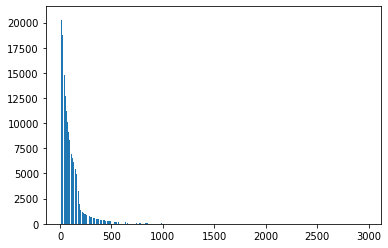

In [20]:
'''
#………………………………2021.05.09用于BERT训练划分训练集、验证集、测试集，对于本分类程序无用………………………………
df1 = df0.iloc[:12349,:]  #取df0前16500条。
df2 = df0.iloc[12349:16465,:]  #取df016500条之后的数据。
df3 = df0.iloc[16465:,:]
df2 = df2.reset_index(drop = True)   #重新设置列索引。
df3 = df3.reset_index(drop = True)   #重新设置列索引。
df1.to_csv("pinglun_train.txt",sep='\t',index=True,header=None)
df2.to_csv("pinglun_dev.txt",sep='\t',index=True,header=None)
df3.to_csv("pinglun_test.txt",sep='\t',index=True,header=None)

x = []
y = []
i = 1
for num in df0[0]:
    num= len(num)
    x.append(num)
    y.append(i)
    i += 1
x = sorted(x,reverse=True)
#x
plt.bar(x,y)
plt.show()
#………………………………2021.05.09用于BERT训练划分训练集、验证集、测试集，对于本分类程序无用………………………………
'''

In [17]:
def cuttxt(x):
    word_list = []
    for line in x:
        wordcut = jieba.lcut(line)
        wordcut = ' '.join(wordcut)
        word_list.append(wordcut)
    return word_list
#df0["cleantxt"] = df0[0].apply(cuttxt)  #直接使用这个的话，cleantxt中每一行皆为一个列表。但下面的方法每一行皆为一个字符串。
word_cut_list = cuttxt(df0[0])
df0['cleantxt'] = word_cut_list
#这里处理后的df0有20582行（即20582条评论），3列。
'''
#以上等价于：
cuttxt = lambda x: " ".join(jieba.lcut(x)) # 这里不做任何清理工作，以保留情感词。
df0["cleantxt"] = df0[0].apply(cuttxt)  #注意这里的apply方法，是将此函数应用于指定列的每一行中。
#编程要高级感，上面一排，仅仅用这两行语句就实现了。
'''

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\YCJ\AppData\Local\Temp\jieba.cache
Loading model cost 0.672 seconds.
Prefix dict has been built successfully.


'\n#以上等价于：\ncuttxt = lambda x: " ".join(jieba.lcut(x)) # 这里不做任何清理工作，以保留情感词。\ndf0["cleantxt"] = df0[0].apply(cuttxt)  #注意这里的apply方法，是将此函数应用于指定列的每一行中。\n#编程要高级感，上面一排，仅仅用这两行语句就实现了。\n'

In [18]:
#from sklearn.feature_extraction.text import CountVectorizer  #此为词频矩阵。经实验，用词频矩阵，预测准确率为83%左右。
from sklearn.feature_extraction.text import  TfidfVectorizer  #此为关键词矩阵。经实验，用关键词矩阵，预测准确率为88%左右。
    #运用支持向量机分类法准确率在91%左右，朴素贝叶斯方法在88%左右，但支持向量机分类法的速度太慢太慢了，基本要慢30倍不止。
    #无论是支持向量机分类法，还是朴素贝叶斯分类法，关键词矩阵都强于词频矩阵。
    #总体上来说，运用朴素贝叶斯方法和支持向量机的的准确率都相对较低，可能还是要用CNN卷积神经网络？

countvec = TfidfVectorizer() # #创建一个CountVectorizer实例，此CountVectorizer类的作用在于创建词袋的数据结构
#countvec = CountVectorizer(min_df = 5)  #这里都可以设停止词，参数为 stop_words = 'english' 。对关键词来说，设不设min_df = 5好像没有影响。

wordmtx = countvec.fit_transform(df0.cleantxt) #利用上面的实例将数据转化为矩阵。wordmtx为转化后的矩阵。
    #这里wordmtx有20582行（即20582条评论），12014列（即在20582条评论中出现次数达5次以上的单词总共有12014个），也就是说每条评论皆是一个高达12014维的稀疏矩阵。

    #注意，这里不能先划分数据集，再向量化，因为用的词频矩阵，所以维度不对。必须先统一向量化再划分词频矩阵。

In [19]:
from sklearn.model_selection import train_test_split   #引入划分训练集和测试集的方法。

x_train, x_test, y_train, y_test = train_test_split(
    wordmtx, df0.y, test_size=0.2,random_state = 111) # 这里直接使用上面创造的共20582个向量，每个向量高达12014维的高维稀疏矩阵wordmtx。
                                        #random_state = 111是指定一个随机数，每次建模如果随机数一样，则建构的结果也一样。

#x_train = countvec.fit_transform(x_train)   #对训练集的数据进行向量矩阵化。
#x_test = countvec.fit_transform(x_test)  #对测试集的数据进行向量矩阵化。维度不对，因为用的词频矩阵，先划分后向量化，那两部分的词并不一样。

'''
train_x,test_x,train_y,test_y = train_test_split(train_data,train_target,test_size=0.3,random_state=5)
train_data：待划分样本数据。
train_target：待划分样本数据的结果（标签）
test_size：测试数据占样本数据的比例，若整数则样本数量。上例为测试集占30%。
random_state：设置随机数种子，保证每次都是同一个随机数。若为0或不填，则每次得到数据都不一样
train_x为训练集的数据，train_y为训练集的结果（即事先标注时打上的标签）。
test_x为训练集的数据，test_y为测试集的结果（即事先标注时打上的标签）。
#整个模型训练原理为先对70%的数据进行训练，训练完成后对剩下的30%进行预测，再用预测所得的结果与事先标的结果进行比对，以此得出正确率和训练效果。
'''

'\ntrain_x,test_x,train_y,test_y = train_test_split(train_data,train_target,test_size=0.3,random_state=5)\ntrain_data：待划分样本数据。\ntrain_target：待划分样本数据的结果（标签）\ntest_size：测试数据占样本数据的比例，若整数则样本数量。上例为测试集占30%。\nrandom_state：设置随机数种子，保证每次都是同一个随机数。若为0或不填，则每次得到数据都不一样\ntrain_x为训练集的数据，train_y为训练集的结果（即事先标注时打上的标签）。\ntest_x为训练集的数据，test_y为测试集的结果（即事先标注时打上的标签）。\n#整个模型训练原理为先对70%的数据进行训练，训练完成后对剩下的30%进行预测，再用预测所得的结果与事先标的结果进行比对，以此得出正确率和训练效果。\n'

In [20]:
from sklearn.svm import SVC  #从sklearn.svm库中引入支持向量机分类法。此方法很慢
#from sklearn import naive_bayes  #从sklearn库中引入朴素贝叶斯分类法。此方法很快。
    #经实验，用支持向量机分类模式，准确率和召回率都明显更高，皆在92%左右，而朴素贝叶斯皆在88%左右。
    #但支持向量机模式太慢了，太慢了。
NBmodel=SVC(kernel = 'rbf', verbose = True)
#NBmodel = naive_bayes.MultinomialNB()   #创建朴素贝叶斯分类的实例，此实例采用多项式分类法（MultinomialNB）。
    #经实验，采用补积ComplementNB分类法的效果跟多项式分类法的效果差不多，皆为88%左右，而伯努利分类法的效果很差，仅有81%左右。
%time NBmodel.fit(x_train, y_train)  #用刚创建的分类实例来拟合模型。x_train为训练集的数据，y_train为训练集的结果（已预先标注）。

[LibSVM]Wall time: 1min 20s


SVC(verbose=True)

In [21]:
%time predict_target = NBmodel.predict(x_test)   #用拟合后的NBmodel模型来预测测试集的数据x_test。输出的是预测出来的测试集结果。下面要将此结果与预先标注结果进行对比。

Wall time: 7.49 s


In [24]:
%time print('训练集：', NBmodel.score(x_train, y_train),'，验证集：', NBmodel.score(x_test, y_test))
%time print(classification_report(y_test, NBmodel.predict(x_test)))

训练集： 0.9928940176131187 ，验证集： 0.9205732329366043
Wall time: 37.7 s


NameError: name 'classification_report' is not defined

In [23]:
predict_data = pd.read_csv('newTrain.csv', lineterminator='\n')
#countvec.vocabulary_
i = 1
for line in predict_data['review'][:100]:    #dfpos表中第0列前100个。
    words = " ".join(jieba.lcut(line))
    words_vecs = countvec.transform([words]) # 数据需要转换为可迭代的list格式
    print(f'第{i}条：{NBmodel.predict(words_vecs)}')
    i +=1

第1条：[0]
第2条：[1]
第3条：[0]
第4条：[1]
第5条：[1]
第6条：[1]
第7条：[1]
第8条：[1]
第9条：[0]
第10条：[1]
第11条：[0]
第12条：[1]
第13条：[0]
第14条：[1]
第15条：[0]
第16条：[1]
第17条：[1]
第18条：[1]
第19条：[0]
第20条：[1]
第21条：[0]
第22条：[0]
第23条：[1]
第24条：[0]
第25条：[1]
第26条：[0]
第27条：[0]
第28条：[1]
第29条：[1]
第30条：[1]
第31条：[0]
第32条：[1]
第33条：[1]
第34条：[0]
第35条：[0]
第36条：[1]
第37条：[1]
第38条：[0]
第39条：[0]
第40条：[0]
第41条：[1]
第42条：[0]
第43条：[1]
第44条：[0]
第45条：[0]
第46条：[0]
第47条：[0]
第48条：[1]
第49条：[1]
第50条：[1]
第51条：[1]
第52条：[1]
第53条：[0]
第54条：[0]
第55条：[0]
第56条：[1]
第57条：[1]
第58条：[1]
第59条：[0]
第60条：[1]
第61条：[0]
第62条：[0]
第63条：[1]
第64条：[0]
第65条：[0]
第66条：[1]
第67条：[1]
第68条：[0]
第69条：[1]
第70条：[1]
第71条：[0]
第72条：[0]
第73条：[1]
第74条：[1]
第75条：[0]
第76条：[0]
第77条：[0]
第78条：[1]
第79条：[1]
第80条：[0]
第81条：[1]
第82条：[1]
第83条：[0]
第84条：[1]
第85条：[1]
第86条：[0]
第87条：[0]
第88条：[0]
第89条：[1]
第90条：[0]
第91条：[1]
第92条：[1]
第93条：[1]
第94条：[0]
第95条：[0]
第96条：[1]
第97条：[0]
第98条：[0]
第99条：[1]
第100条：[0]
